In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

<font size="10">Data Loading</font>

In [3]:
df = pd.read_excel("premiums.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4.0
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3.0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4.0


In [4]:
df.shape

(50000, 14)

In [5]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4.0
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3.0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4.0


<font size="10">Exploratory Data Analysis & Data Cleaning</font>

### Handle Missing Values

In [6]:
df.isna().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status              11
employment_status            2
income_level                13
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
genetical_risk           29904
dtype: int64

In [7]:
df.drop('genetical_risk', axis=1, inplace=True)

We can see most of the rows have missing genetical_risk. We can drop this column.

In [8]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [9]:
df.duplicated().sum()

0

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


#### Data Cleaning: number_of_dependants

In [12]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

We can see some negative values in number_of_dependants. We can replace them with positive numbers

In [13]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [14]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns  

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

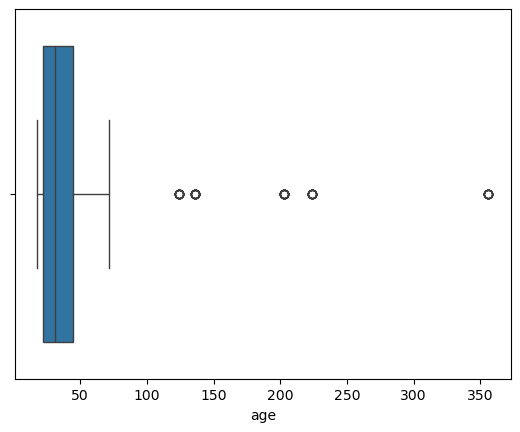

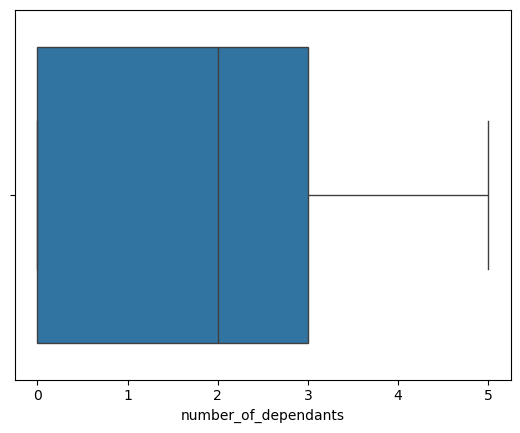

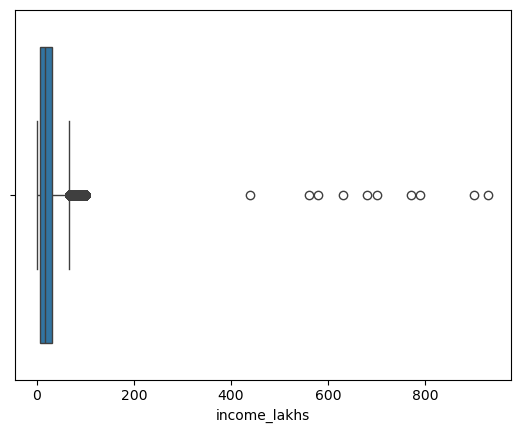

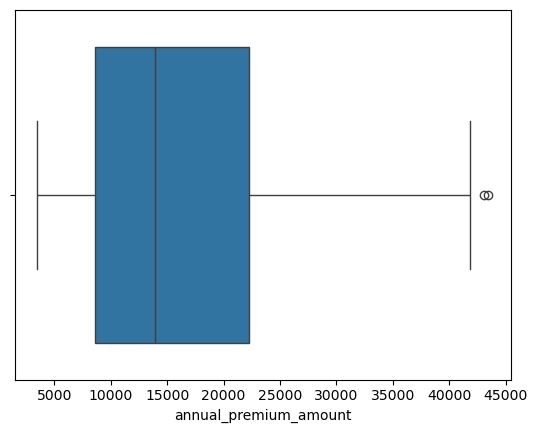

In [15]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

We can see that there are outlier in age and income_lakhs

### Outlier Treatment: Age Column

In [16]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [17]:
df1 = df[df.age<=100]
df1.age.describe()

count    49918.000000
mean        34.401839
std         13.681600
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [18]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-29.0, 67.0)

In [19]:
df1[df1.income_lakhs>upper].shape

(3559, 13)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence we decided to use a simple quantile bound.

In [20]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [21]:
df1[df1.income_lakhs>quantile_thresold].shape

(10, 13)

In [22]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.shape

(49908, 13)

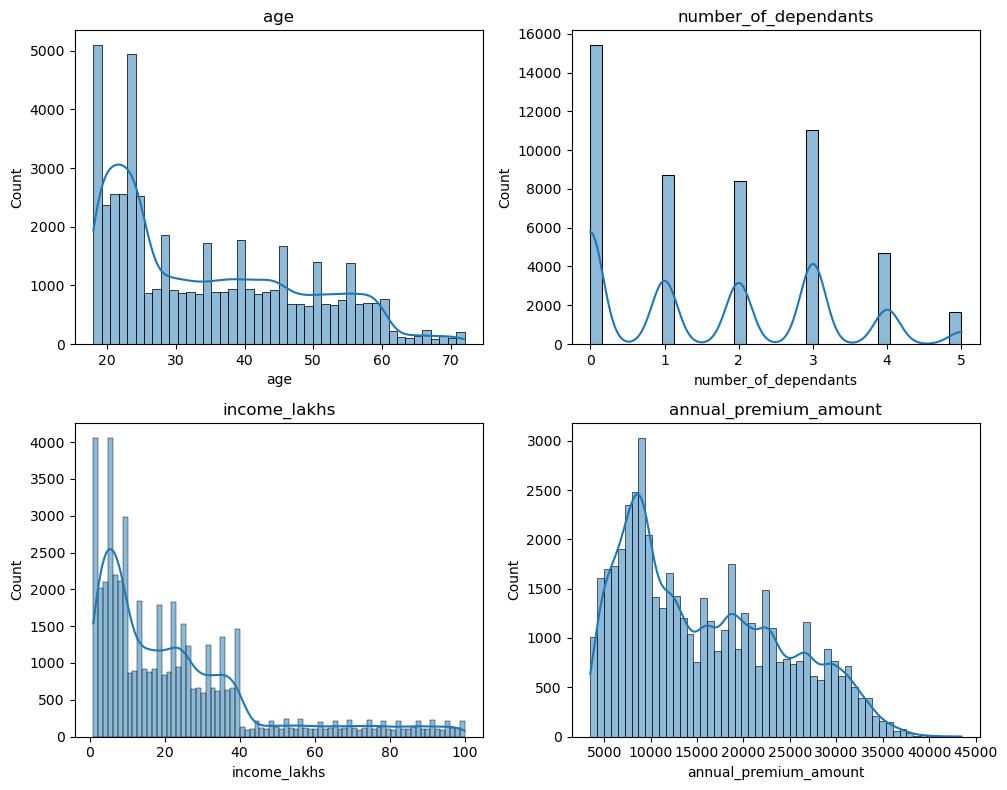

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [24]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


### Bivariate Analysis: Numeric Columns

In [25]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

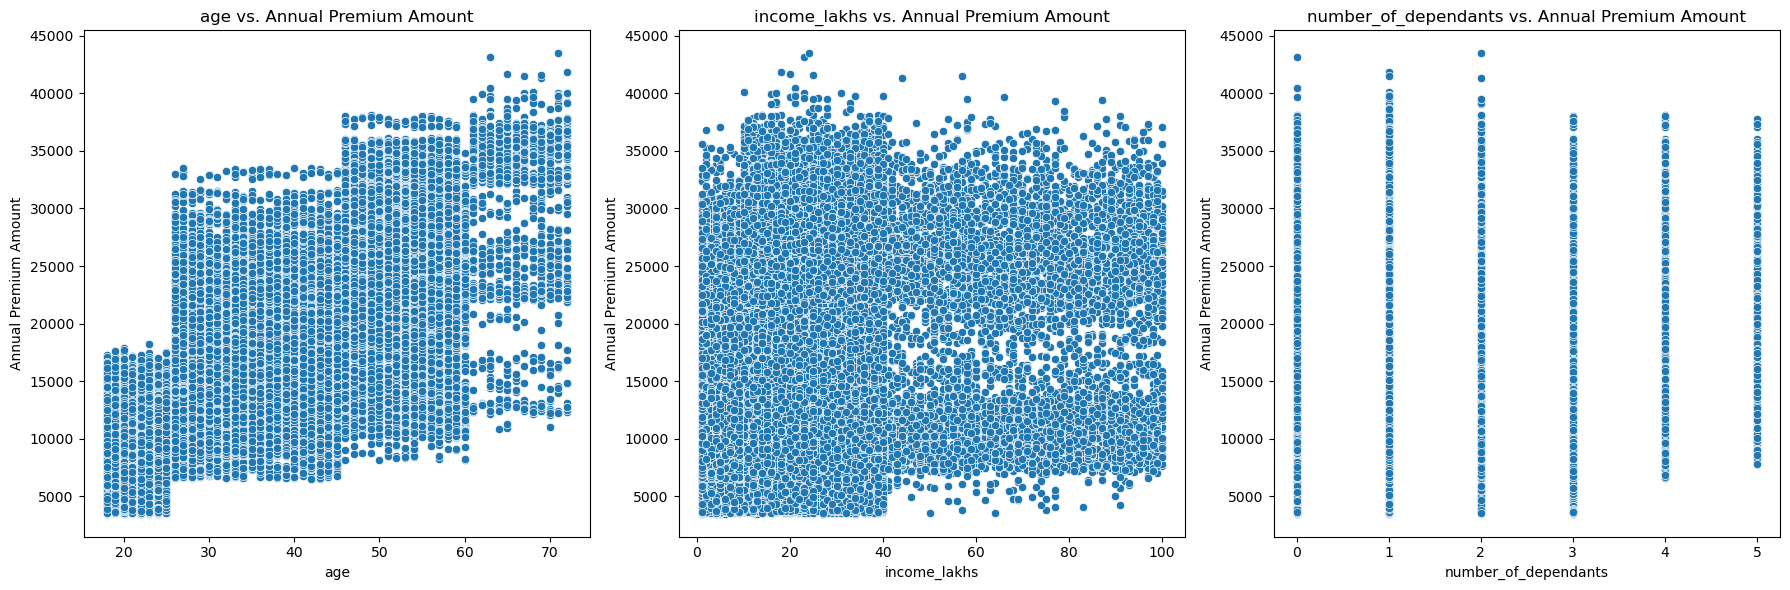

In [26]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [27]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [28]:
df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis

In [29]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [30]:
pct_count = df2['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      54.963132
Female    45.036868
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

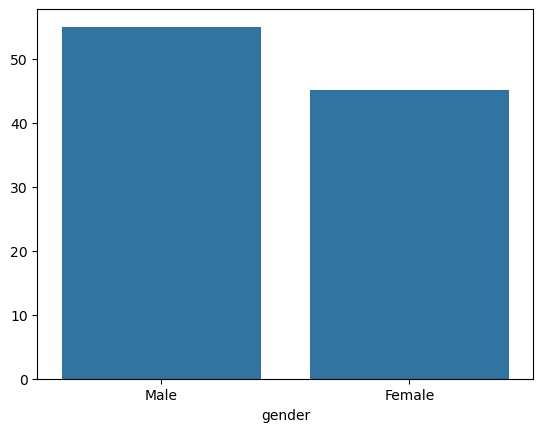

In [31]:
sns.barplot(x=pct_count.index, y=pct_count.values)

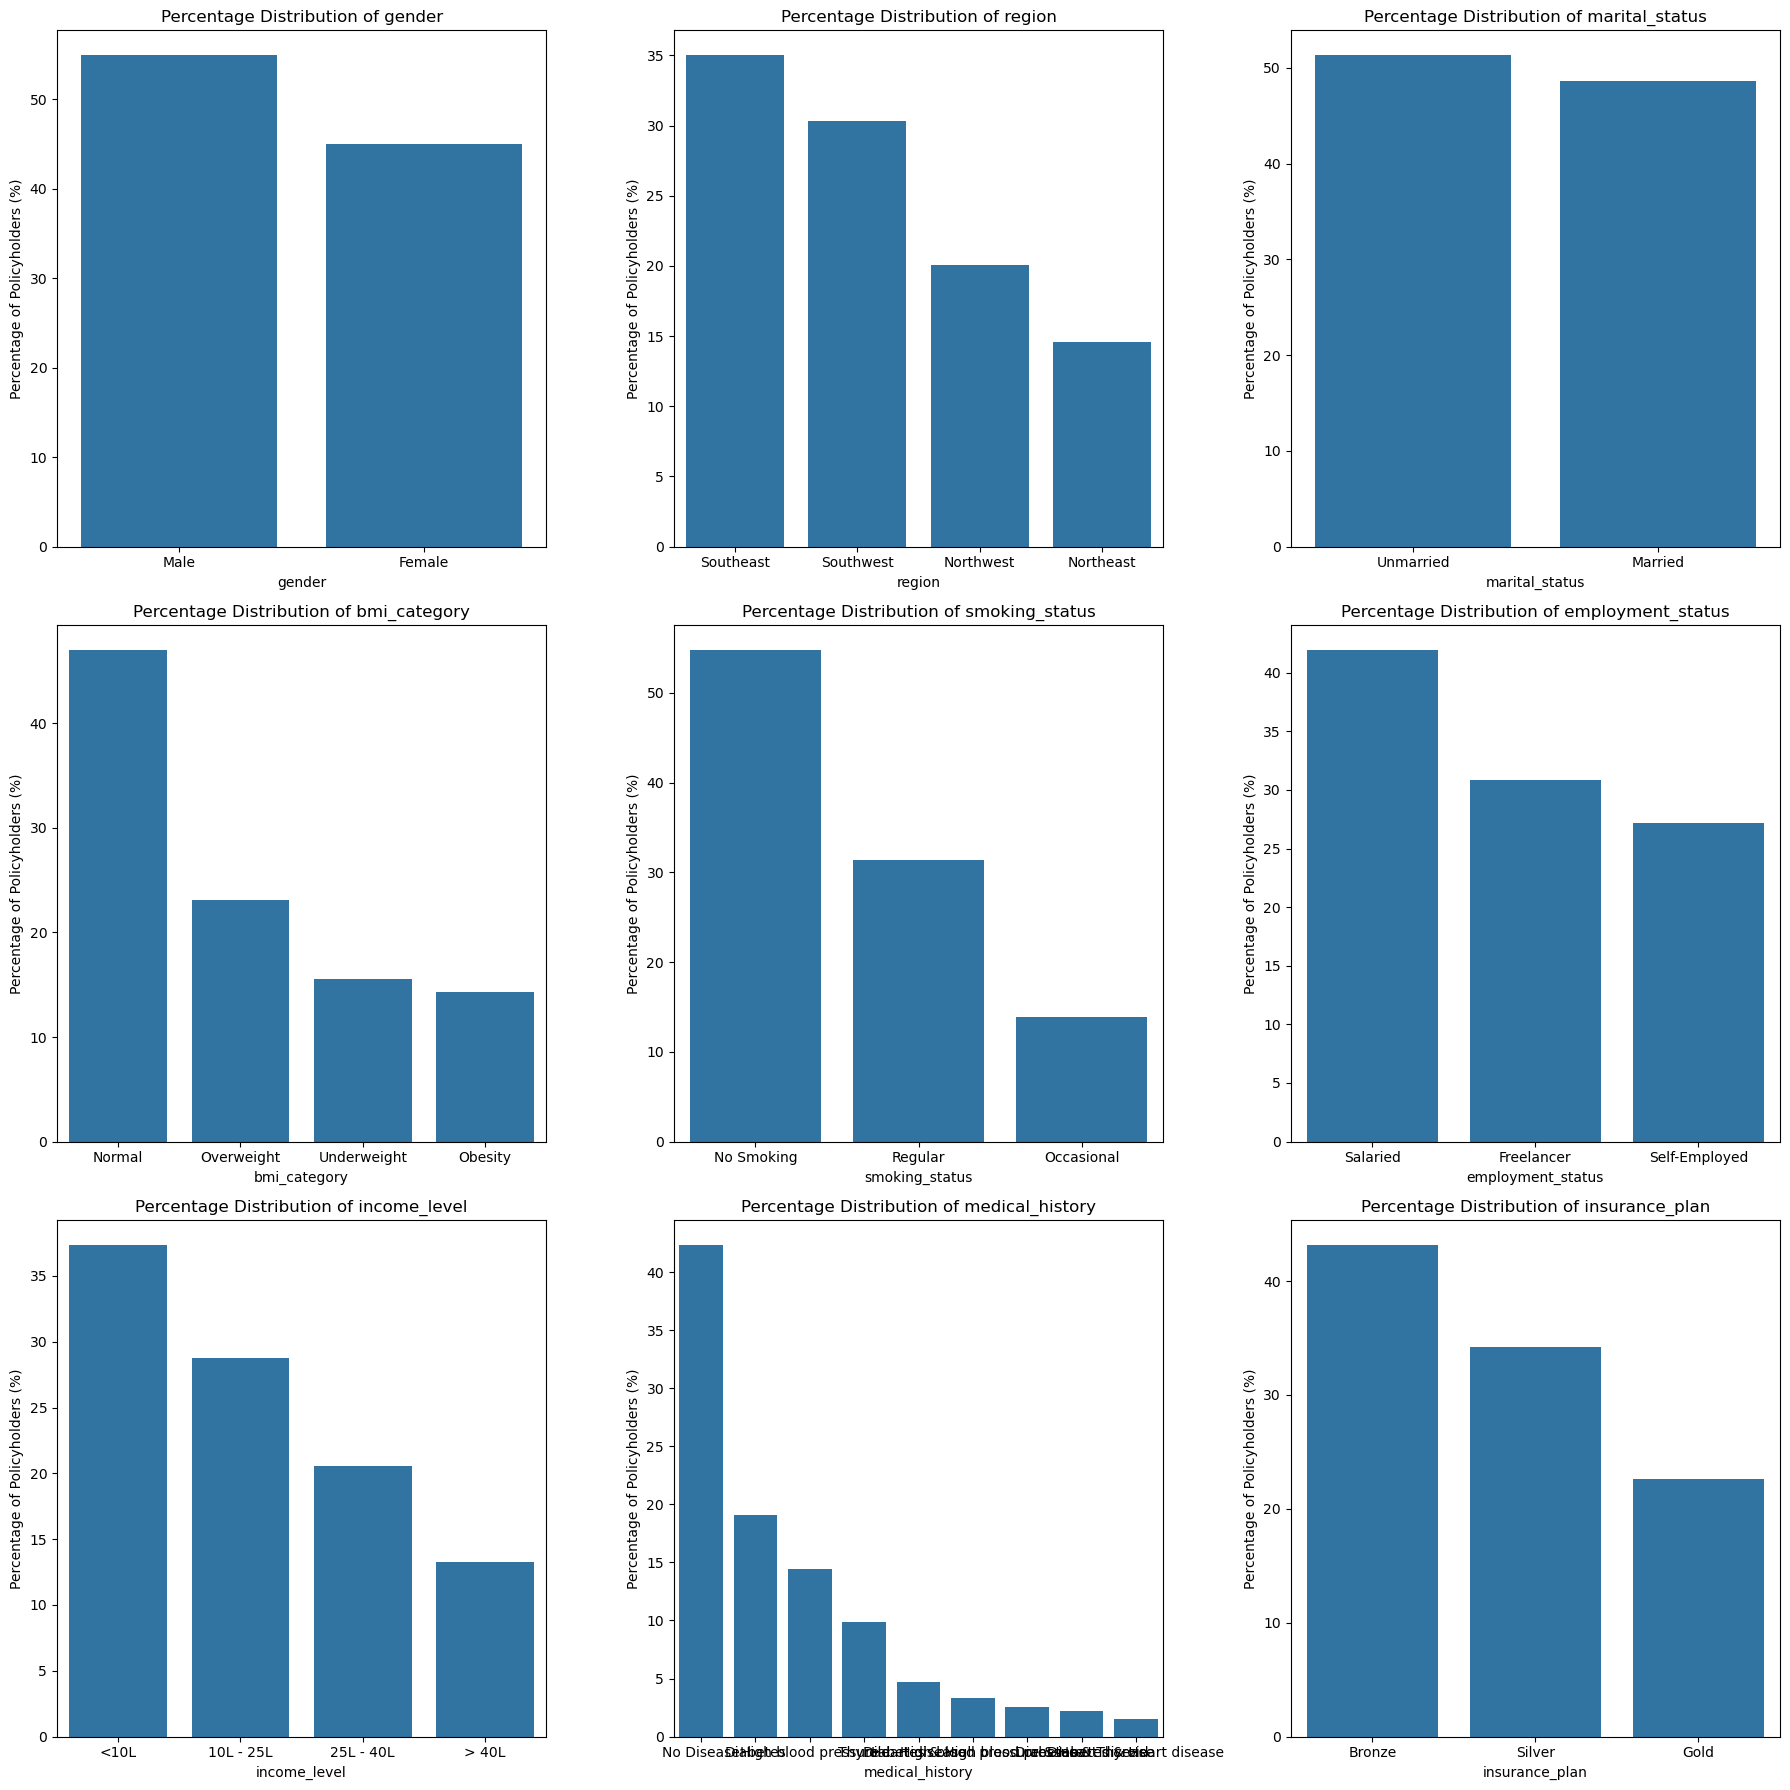

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


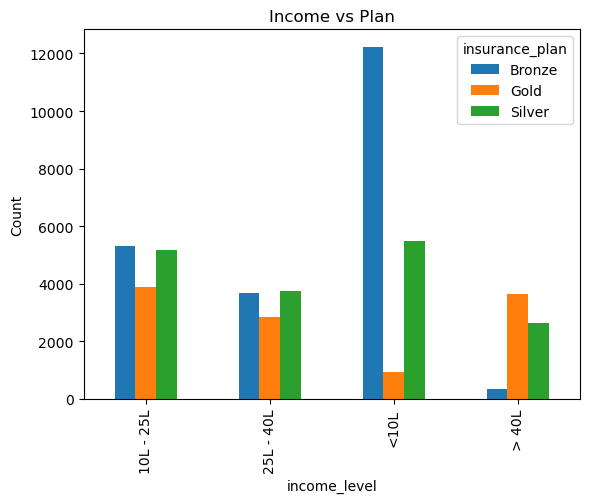

In [33]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

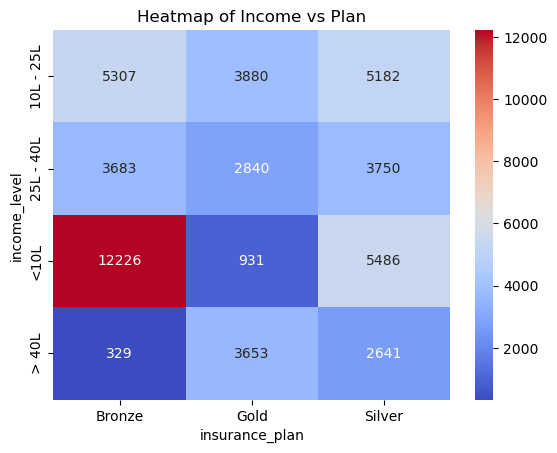

In [34]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<font size="10">Feature Engineering</font>

In [35]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


### Calculate Risk Score

In [36]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Encode Text Columns

In [37]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [38]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [39]:

df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [40]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0


In [41]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease1                         49908 non-null  object 
 8   disease2                         49908 non-null  object 
 9   total_risk_score                 49908 non-null  int64  
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int32  
 12  region_Northwest       

### Feature Selection

In [42]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


### Calculate VIF for Multicolinearity

In [43]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

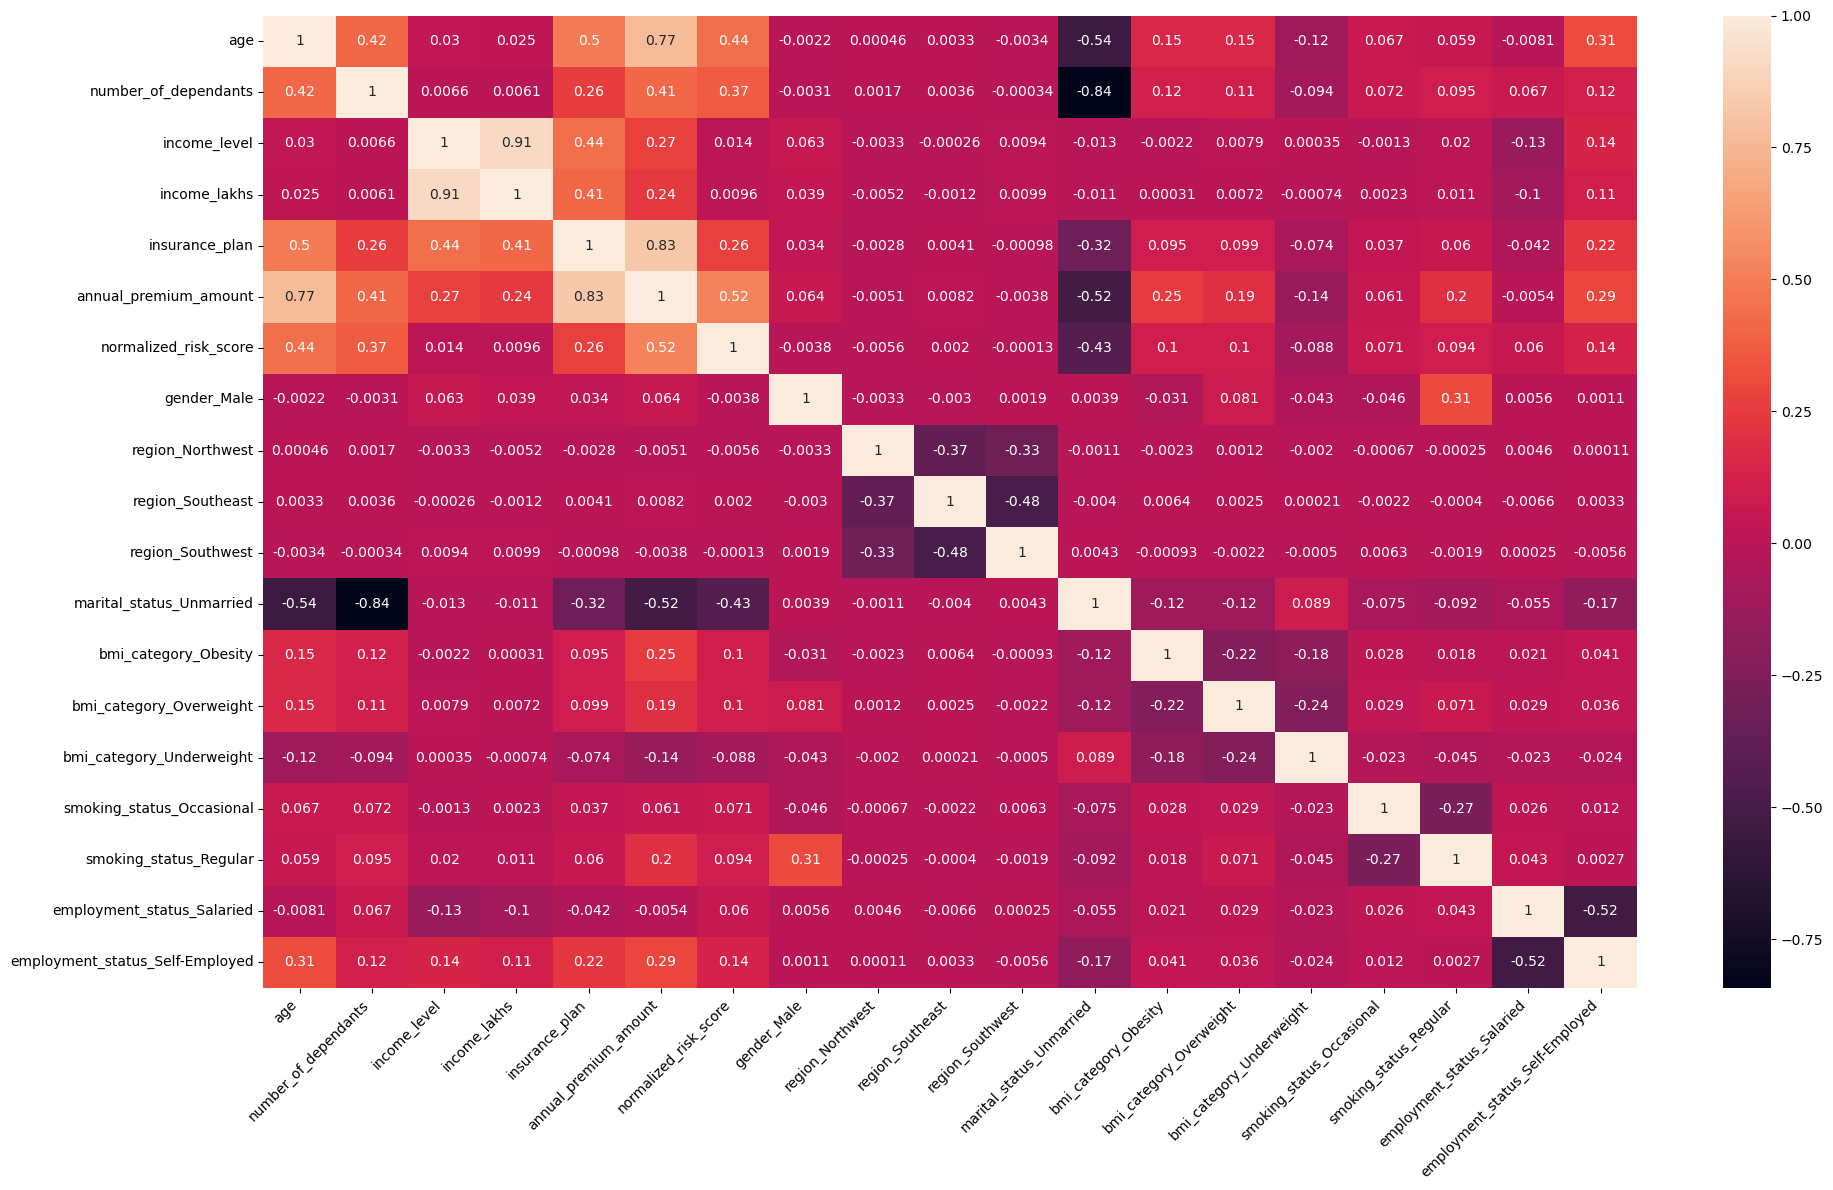

In [44]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [47]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


income_level and income_lakhs have high VIF.

In [48]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [49]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<font size="10">Model Training</font>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


### Linear Regression Model

In [51]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9273006108343986, 0.9302494001635655)

In [52]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  4934028.211803513 RMSE:  2221.26725357475


In [53]:
X_test.shape

(14973, 17)

In [54]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([11279.270937,  -528.675154,  -402.625319, 12491.875692,
        4810.715429,   149.966275,   -43.554538,    20.218315,
         -22.705767,  -836.921276,  3357.546583,  1621.682544,
         349.185823,   738.576475,  2235.981237,   155.916435,
         374.237773])

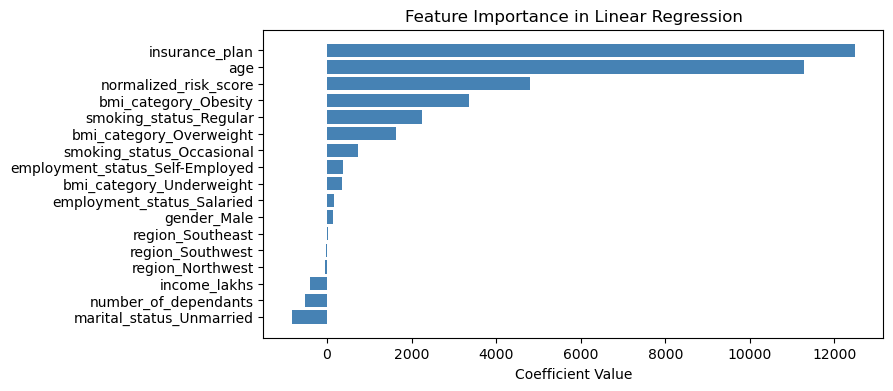

In [55]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [56]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9273005728537909, 0.930249309713187)

In [57]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  4934034.610095719 RMSE:  2221.26869380895


### XGBoost 

In [58]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9781342001566424

In [59]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1546746.1721299824 RMSE:  1243.6825045525013


In [60]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9808370338437263

In [61]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [62]:
best_model = random_search.best_estimator_

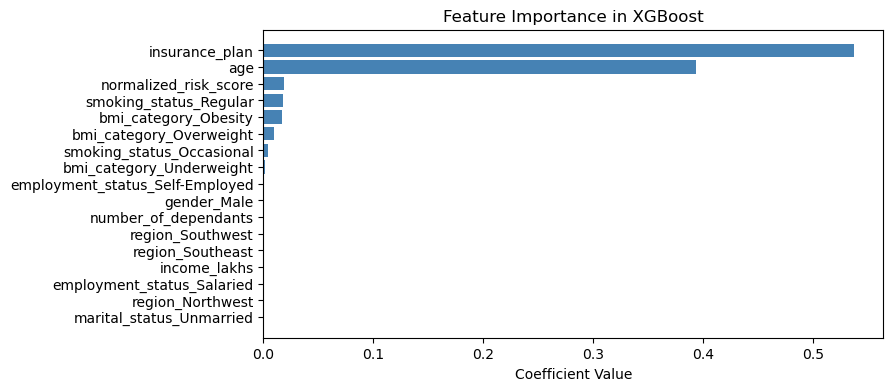

In [63]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [64]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3591,5566,6748.037109,1182.037109,21.236743
35782,14238,13908.824219,-329.175781,-2.311952
43602,25519,24974.671875,-544.328125,-2.133031
42722,8968,9534.389648,566.389648,6.315674
18903,9138,7139.514648,-1998.485352,-21.870052


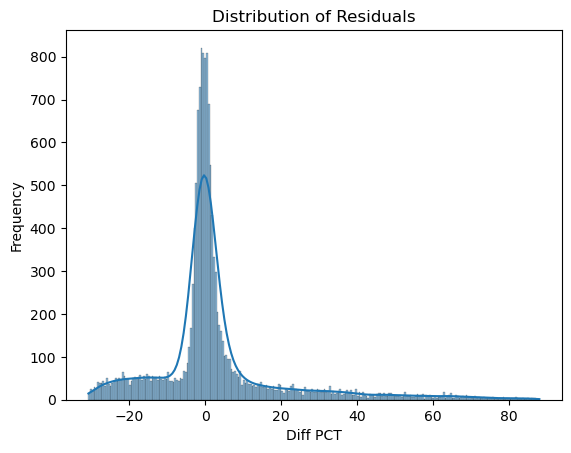

In [65]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [66]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
3591,5566,6748.037109,1182.037109,21.236743
18903,9138,7139.514648,-1998.485352,-21.870052
4284,8844,6573.528809,-2270.471191,-25.672447
3145,10181,8055.894043,-2125.105957,-20.873254
732,5212,7120.876953,1908.876953,36.624654


In [67]:
extreme_results_df.shape

(4423, 4)

In [68]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

29.539838375743003

We have 30% extreme errors which means for 30% customers we will either overcharge or undercharge by 10% or more

In [69]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
7299,3505,6591.870117,3086.870117,88.070474
2975,3503,6573.528809,3070.528809,87.654262
641,3522,6591.870117,3069.870117,87.162695
13751,3526,6591.870117,3065.870117,86.950372
8318,3527,6591.870117,3064.870117,86.897367
...,...,...,...,...
10227,4380,6577.108887,2197.108887,50.162303
4467,4372,6564.089844,2192.089844,50.139292
19320,4807,7215.747559,2408.747559,50.109165
884,4749,7128.062012,2379.062012,50.096063


There will be about 549 customers whom we will overcharge or underchage by more than 50%

In [70]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3591,0.055556,0.2,0.070707,0.0,0.0,1,1,0,0,1,0,0,0,1,0,0,1
18903,0.129630,0.0,0.080808,0.0,0.0,0,0,0,0,1,0,0,0,0,1,1,0


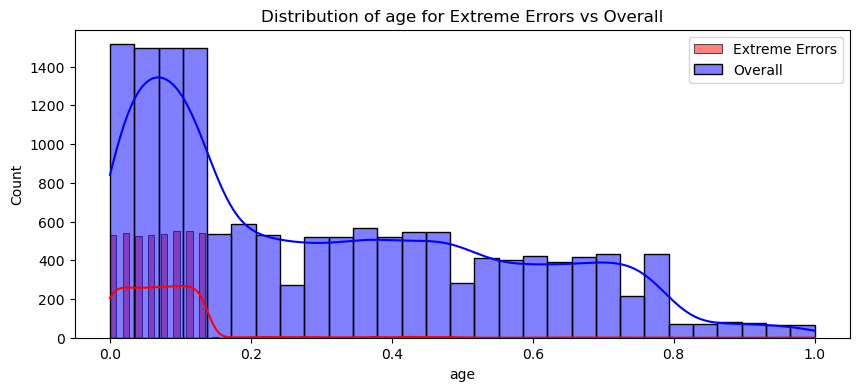

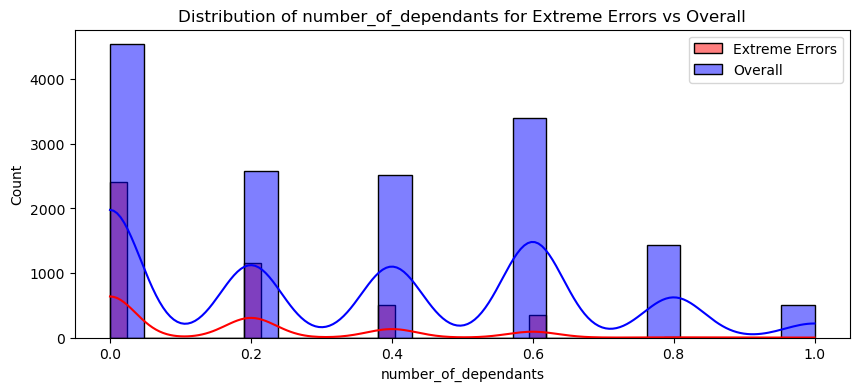

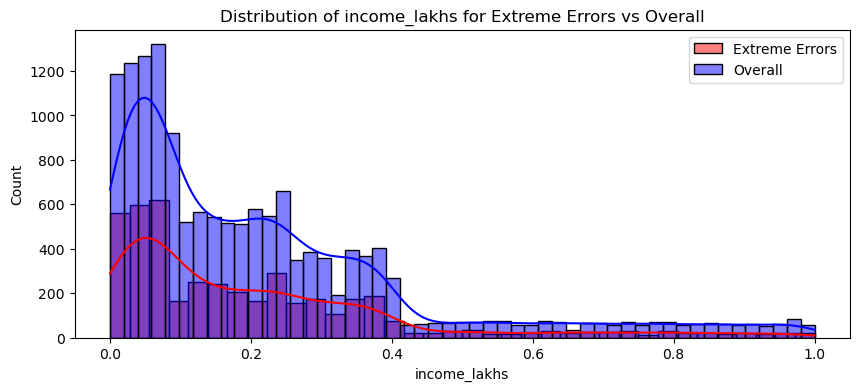

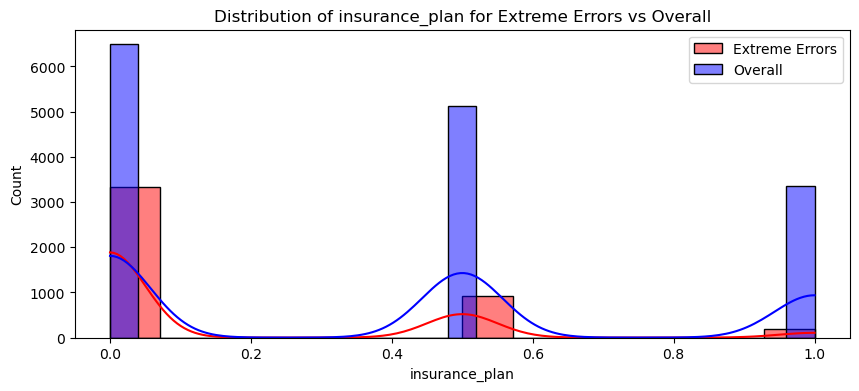

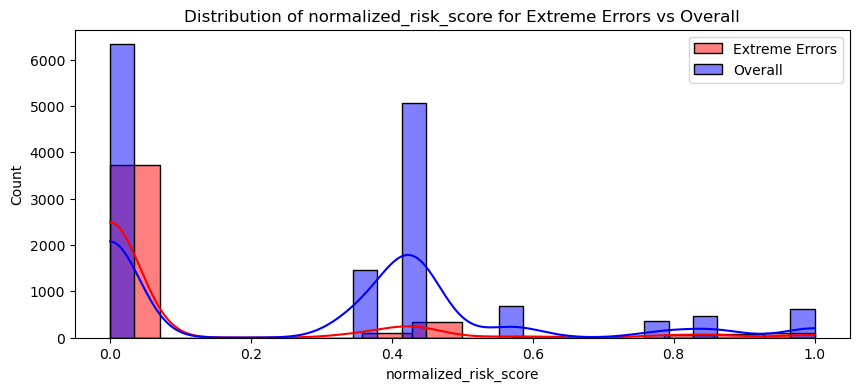

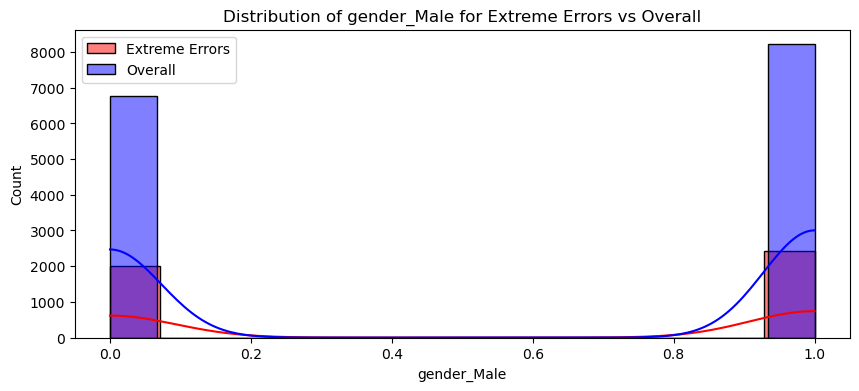

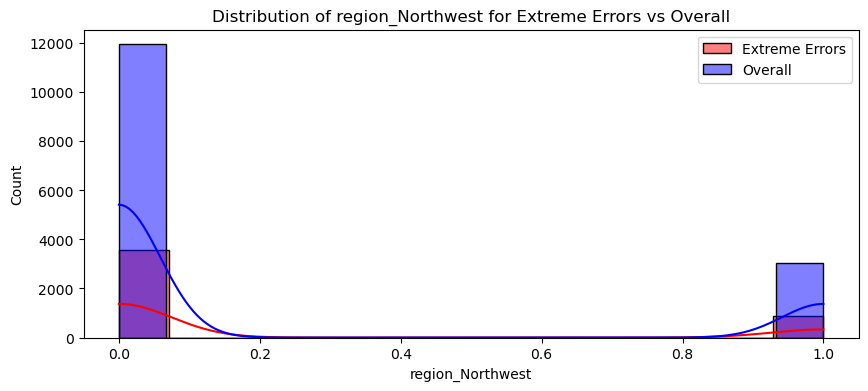

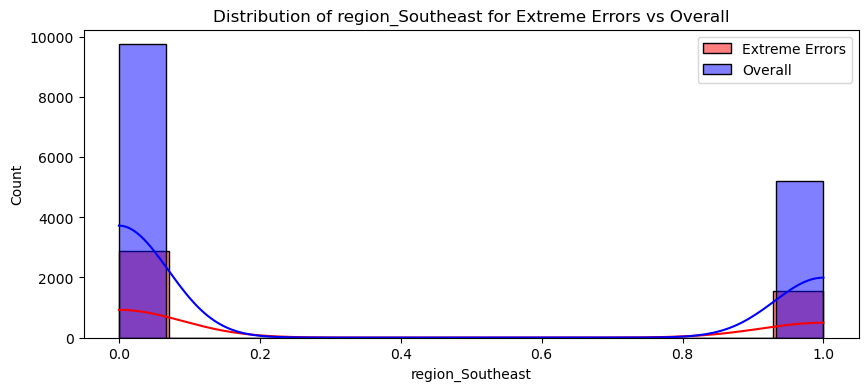

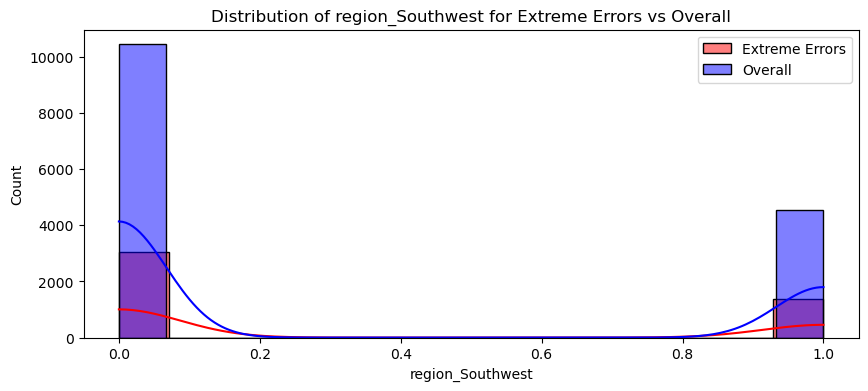

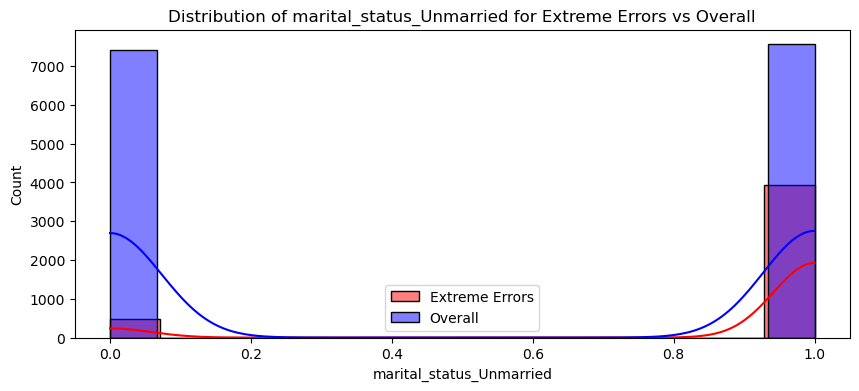

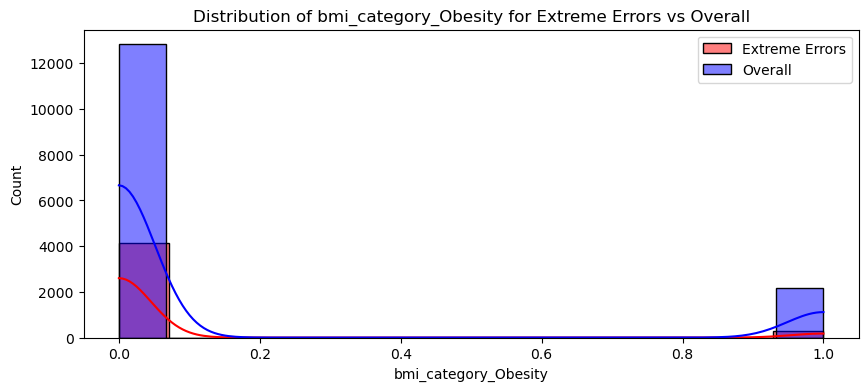

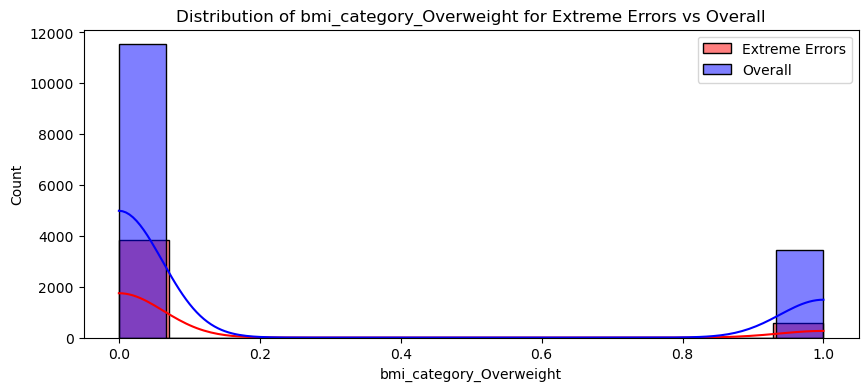

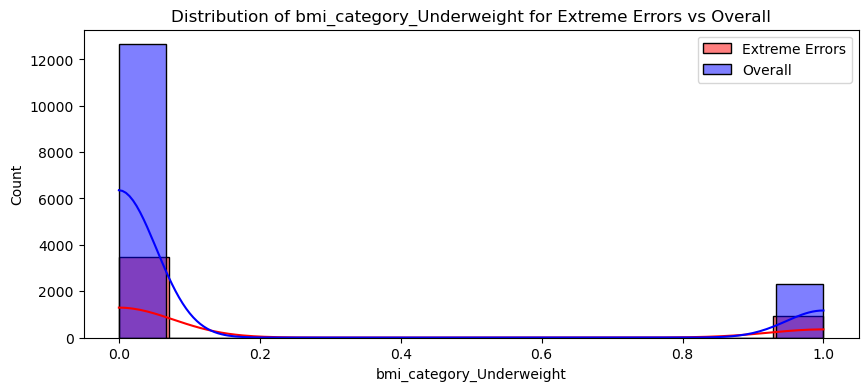

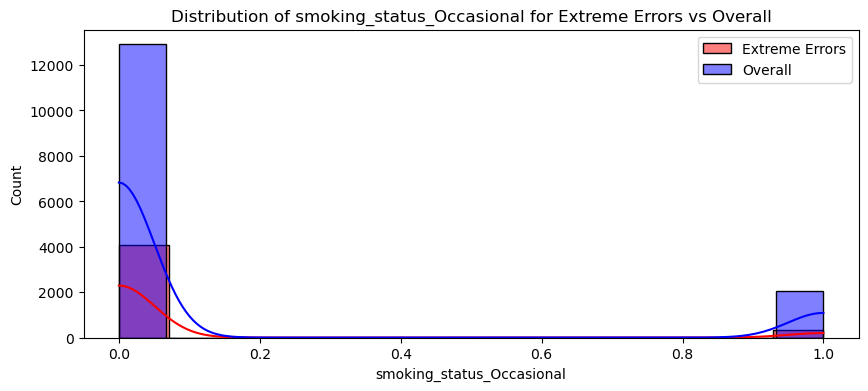

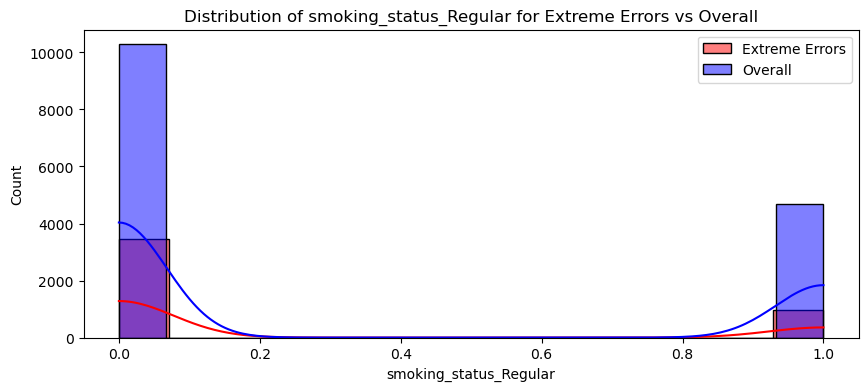

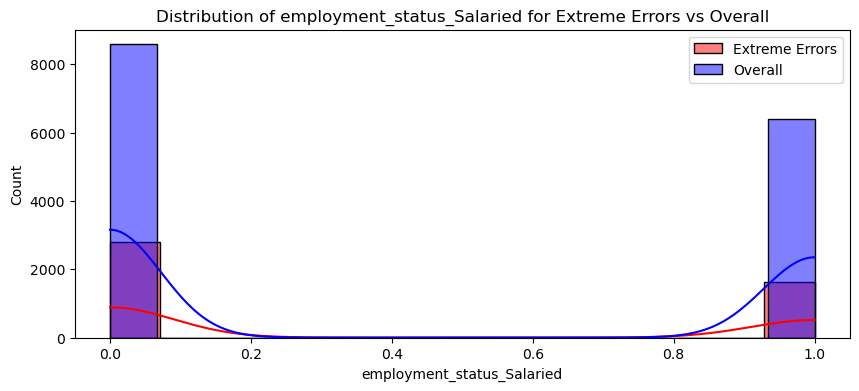

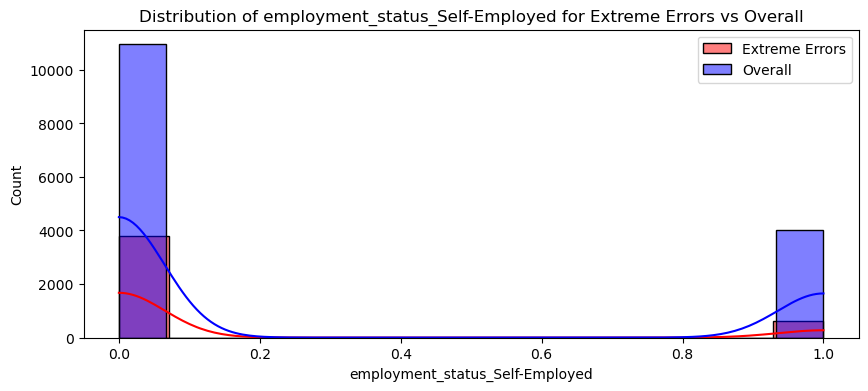

In [71]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### Reverse Scaling

In [72]:
extreme_errors_df['income_level']=-1

In [73]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,21.0,1.0,-2.0,8.0,1.0
1,25.0,0.0,-2.0,9.0,1.0
2,21.0,1.0,-2.0,14.0,1.0
3,21.0,1.0,-2.0,2.0,1.0
4,23.0,0.0,-2.0,25.0,1.0


In [74]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4423.000000,4423.000000,4423.0,4423.000000,4423.000000
mean,21.947547,0.733213,-2.0,21.102871,1.290753
std,3.708933,0.964216,0.0,20.620915,0.538876
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,29.000000,1.000000
max,72.000000,5.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

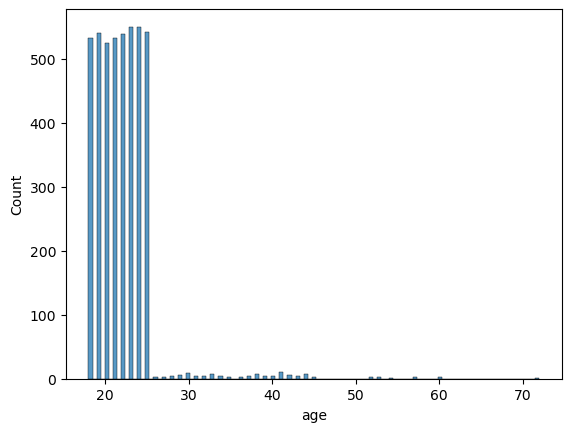

In [75]:
sns.histplot(df_reversed.age)

This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age). We need to may be build a separate model for this segment